<span style="color:gray">Интеллектуальный анализ данных в R и Python. Лекция 2</span>

### 2.  Обучение с учителем. Модель логистической регрессии.

<font color='blue'>Логистическая регрессия</font> представляет собой линейную модель для решения задачи классификации с использованием логистической (сигмоидальной) функции, которая определяет вероятность принадлежности к определенному классу. Задача оптимизации заключается в следующем:
$$
\underset{\theta}{min\,} \sum_{i=1}^n \log(\exp(- y_i (X_i^T \theta + c)) + 1) .
$$

Логистическая регрессия реализована в [`sklearn.linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Для более подробной информации [1.1.11. Logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) в документации scikit-learn.

Метод [`sklearn.linear_model.LogisticRegression.predict_proba`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) возвращает вероятность для каждого класса (от 0 до 1), тогда как метод [`sklearn.linear_model.LogisticRegression.decision_function`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.decision_function) возвращает доверительный интервал (от -1 до 1).

Воспользуемся функций [`sklearn.datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) для генерации синтетических данных для классификации.

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

Создадим функцию для построения разделяющей гиперплоскости и визуализации результатов классификации calculate_decision_function().

In [59]:
def calculate_decision_function(X,model):
    '''
    Create a 2D grid to evaluate model.
    '''

    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model(xy).reshape(XX.shape)

    return (XX,YY,Z)

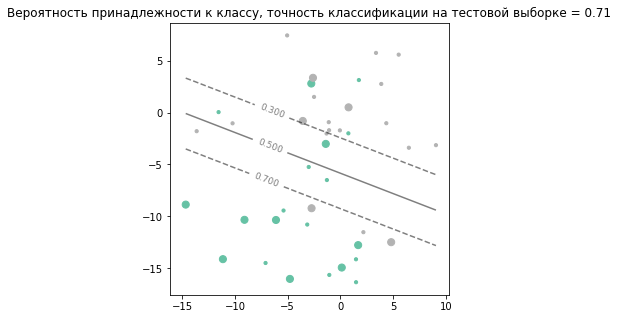

In [60]:
# генерируем выборку из 40 линейно разделимых наблюдений
# с количеством классов "centers" и разбросом их значений "cluster_std" (рез. точность 0.75)
#X, y = make_blobs(n_samples=40, centers=2, cluster_std=4.0, random_state=2)

#пробуем уменьшить кол-во наблюдений
#X, y = make_blobs(n_samples=25, centers=2, cluster_std=4.0, random_state=2)
#пробуем увеличить кол-во наблюдений
#X, y = make_blobs(n_samples=55, centers=2, cluster_std=4.0, random_state=2)
#уменьшаем диапазон
#X, y = make_blobs(n_samples=40, centers=2, cluster_std=2.5, random_state=2)
#увеличиваем диапазон
X, y = make_blobs(n_samples=40, centers=2, cluster_std=5.5, random_state=2)
# разбиваем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# строим модель логистической регрессии
model = Pipeline([('logistic', LogisticRegression())]) 
model.fit(X_train, y_train)

# строим метрику для оценки качества модели
accuracy_test = model.score(X_test,y_test) 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Set2)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=plt.cm.Set2)

(XX,YY,Z) = calculate_decision_function(X, lambda x: model.predict_proba(x)[:,0])
CS = ax.contour(XX, YY, Z, colors='k', levels=[0.3, 0.5, 0.7], alpha=0.5, linestyles=['--', '-', '--'])
ax.clabel(CS, fontsize=9, inline=1)
ax.set(title='Вероятность принадлежности к классу, точность классификации на тестовой выборке = ' + '{0:.2f}'.format(accuracy_test))

plt.show();

Качество классификации оценивается с помощью <font color='blue'>матрицы неточностей</font> (confusion matrix)


\begin{array}{rr} \hline
& & & \color{blue}{\text{Прогноз класса}} \\ 
& & \color{green}{\text{positives}} & \color{green}{\text{negatives}} \\ 
\color{blue}{\text{Истинный}} & \color{green}{\text{positives}} & TP & FN \\ 
\color{blue}{\text{класс}} & \color{green}{\text{negatives}} & FP & TN \\ \hline
\end{array}

которая реализована в [`sklearn.metrics.confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [61]:
print(confusion_matrix(y_test, model.predict(X_test)))

[[7 2]
 [2 3]]


Альтернативным вариантом является функция Pandas [`pandas.crosstab`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html).

In [62]:
pd.crosstab(pd.Series(y_test,name='Истинный класс'), 
            pd.Series(model.predict(X_test),name='Прогноз класса'),
            margins=True)

Прогноз класса,0,1,All
Истинный класс,,,
0,7,2,9
1,2,3,5
All,9,5,14


Показатели оценки качества модели могут быть получены с помощью функции [`sklearn.metrics.classification_report`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 

In [63]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.60      0.60      0.60         5

    accuracy                           0.71        14
   macro avg       0.69      0.69      0.69        14
weighted avg       0.71      0.71      0.71        14



Метрики точности (precision), полноты (recall) и $F_1$ меры определяются как:

$$
\text{precision} = \frac{TP}{TP + FP}
$$

$$
\text{recall} = \frac{TP}{TP + FN}
$$

$$
F_1 = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$

где TP - количество истинных положительных примеров (true positives), TN - количество истинных отрицательных примеров (false positives), FP - количество ложных положительных примеров (false positives), FN - количество ложных отрицательных примеров (false negatives). Более подробная информация приведена по ссылке [3.3.2.8. Precision, recall and F-measures](http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures) в документации scikit-learn.

<font color='green'>Задание для самостоятельной работы:</font>

1. Построить модель логистической регрессии на сгенерированном наборе данных, запуская ячейки в данном Jupyter Notebook и меняя значения параметров модели и метрик. 
1. Создать ячейку и написать пояснение, как количество наблюдений n_samples и разброс значений cluster_std влияет на качество бинарной классификации (centers=2). 
1. Загрузить результирующий .ipynb файл в папку /assignments/. Файлы должны именоваться как:<br>
   *'Lecture_2_' + surname*.

#### Влияние от кол-ва наблюдений  
Точность уменьшается при увеличении n_samples

#### Влияние от диапазона значений
Точность уменьшается при увеличении разброса cluster_std
